<a href="https://colab.research.google.com/github/Alphatrion-star/github-pages/blob/main/walmart_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# Walmart analysis and forcasting




In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

In [2]:
ur='https://raw.githubusercontent.com/Alphatrion-star/github-pages/refs/heads/main/Walmart.csv'
df=pd.read_csv(ur)
df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


## <span style='color: GREEN;'>__*EDA & ANALYSIS*__</span>

In [3]:
df['Date'] = pd.to_datetime(df['Date'], format="%d-%m-%Y")

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Store         6435 non-null   int64         
 1   Date          6435 non-null   datetime64[ns]
 2   Weekly_Sales  6435 non-null   float64       
 3   Holiday_Flag  6435 non-null   int64         
 4   Temperature   6435 non-null   float64       
 5   Fuel_Price    6435 non-null   float64       
 6   CPI           6435 non-null   float64       
 7   Unemployment  6435 non-null   float64       
dtypes: datetime64[ns](1), float64(5), int64(2)
memory usage: 402.3 KB
None


### <span style='color: GREEN;'>__*(a) Weekly sales vs Unemployment*__</span>


Correlation (Weekly Sales vs Unemployment):
positive relation in Store
36    0.833734
35    0.483865
21    0.218367
14    0.210786
30    0.201862
dtype: float64 

negative relation in Store
38   -0.785290
44   -0.780076
39   -0.384681
42   -0.356355
41   -0.350630
dtype: float64


/tmp/ipython-input-3639679970.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  store_corr = df.groupby('Store').apply(lambda x: x['Weekly_Sales'].corr(x['Unemployment']))


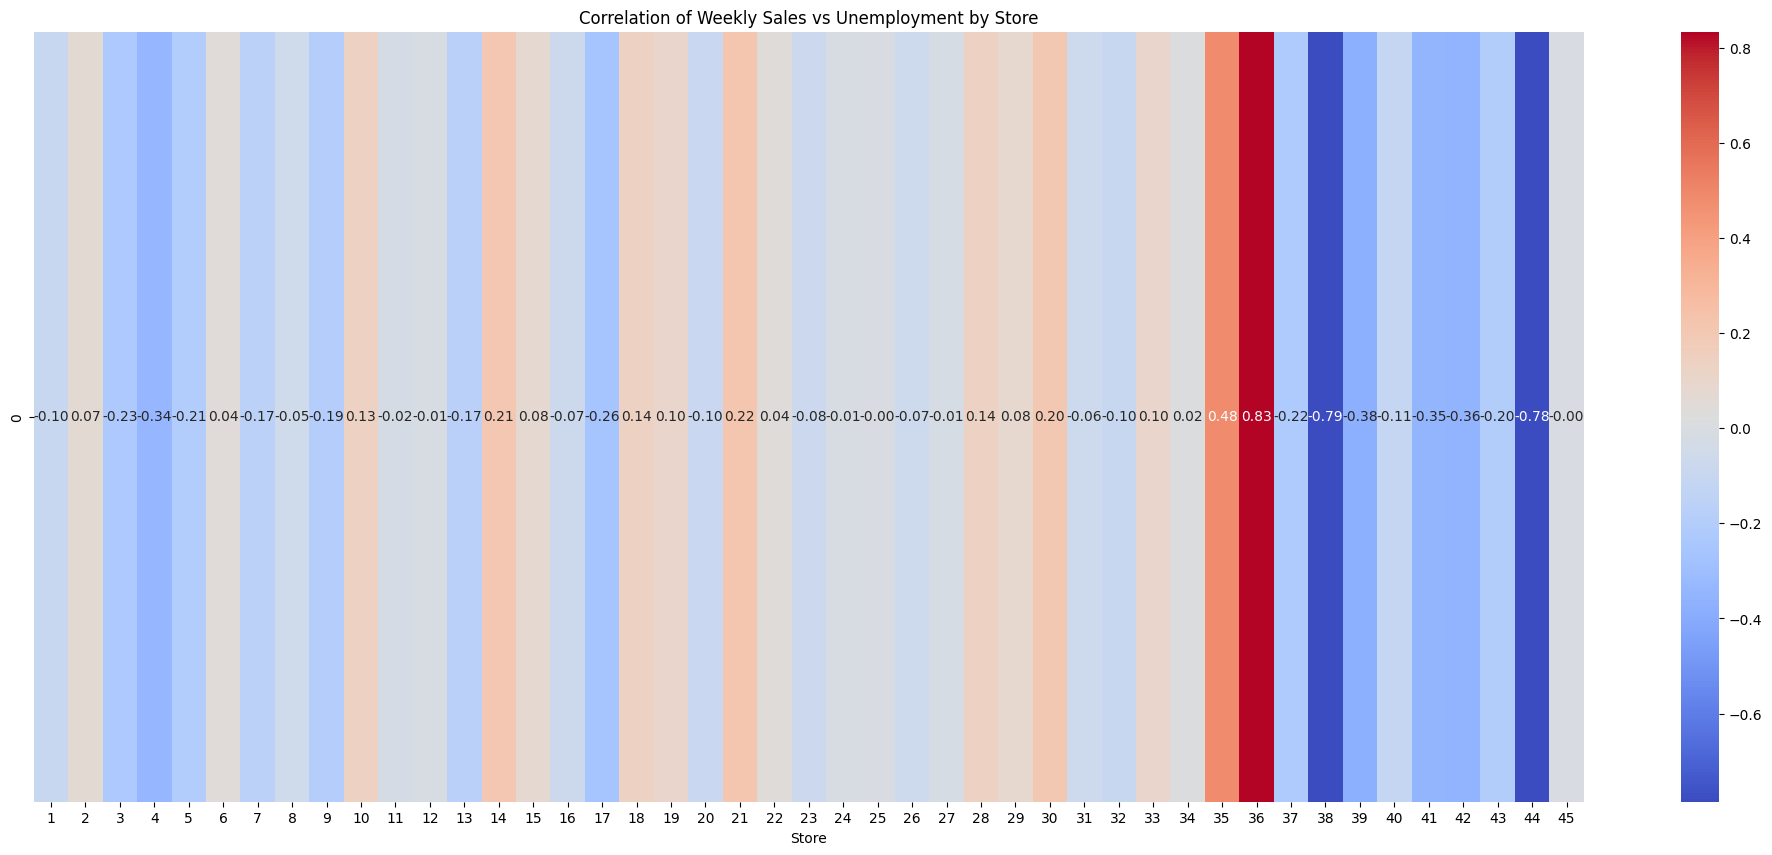

In [4]:
store_corr = df.groupby('Store').apply(lambda x: x['Weekly_Sales'].corr(x['Unemployment']))
print("\nCorrelation (Weekly Sales vs Unemployment):")
print('positive relation in',store_corr.sort_values(ascending=False).head(),'\n')
print('negative relation in',store_corr.sort_values().head())

plt.figure(figsize=(25, 10))
sns.heatmap(store_corr.reset_index().set_index("Store").T, cmap="coolwarm", annot=True, fmt=".2f")
plt.title("Correlation of Weekly Sales vs Unemployment by Store")
plt.show()

- Looks like (store no-36) shows a positive correlation to sales by unemployment.
- (store no-38 and 44) shows a negative correlation to sales by unemployment which highly shows that these stores can operate well even without many employees.


### <span style='color: GREEN;'>__*(b) Seasonal trends*__</span>

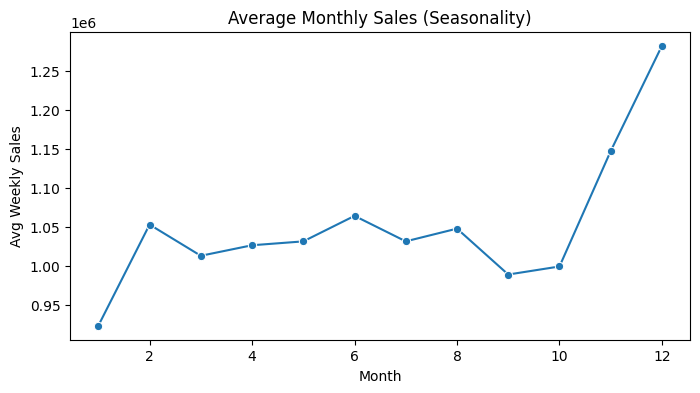

In [5]:
df['Month'] = df['Date'].dt.month
monthly_sales = df.groupby('Month')['Weekly_Sales'].mean()

plt.figure(figsize=(8,4))
sns.lineplot(x=monthly_sales.index, y=monthly_sales.values, marker="o")
plt.title("Average Monthly Sales (Seasonality)")
plt.xlabel("Month")
plt.ylabel("Avg Weekly Sales")
plt.show()

- the average weekly sales are constantly increasing from October to December and the sales fall back in January.
- this can be due to holidays and festival celebrations during these three months

### <span style='color: GREEN;'>__*(c) Temperature effect*__</span>

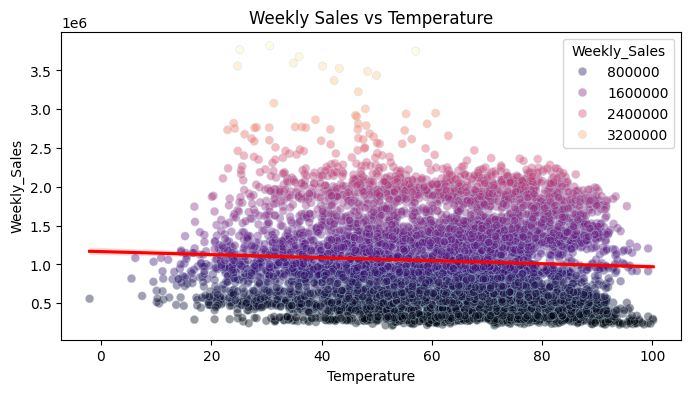

In [6]:
plt.figure(figsize=(8,4))
sns.scatterplot(data=df, x="Temperature", y="Weekly_Sales",hue='Weekly_Sales',palette="magma",edgecolor='lightblue',alpha=0.4)
sns.regplot(data=df, x="Temperature", y="Weekly_Sales", scatter=False, color="red")
plt.title("Weekly Sales vs Temperature")
plt.show()

- From the above graph there is no significant changes in weekly_Sales with respective to temperature

### <span style='color: GREEN;'>__*(d) CPI effect*__</span>

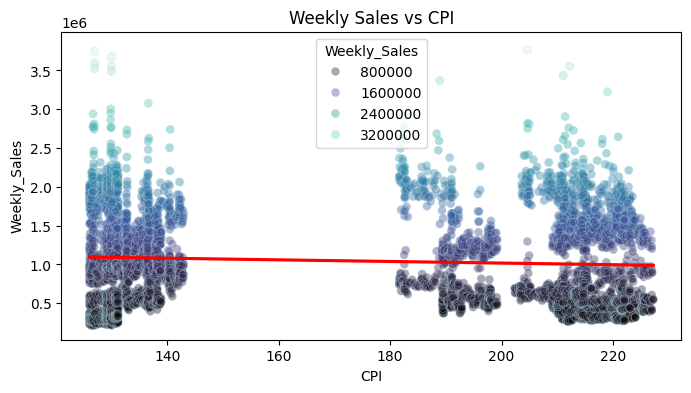

In [7]:
plt.figure(figsize=(8,4))
sns.scatterplot(data=df, x="CPI", y="Weekly_Sales",hue='Weekly_Sales',palette='mako',edgecolor='lightblue',alpha=0.4)
sns.regplot(data=df, x="CPI", y="Weekly_Sales", scatter=False, color="red")
plt.title("Weekly Sales vs CPI")
plt.show()

- There is no significant changes in Weekly_Sales due to CPI

### <span style='color: GREEN;'>__*(e) Top performing stores*__</span>

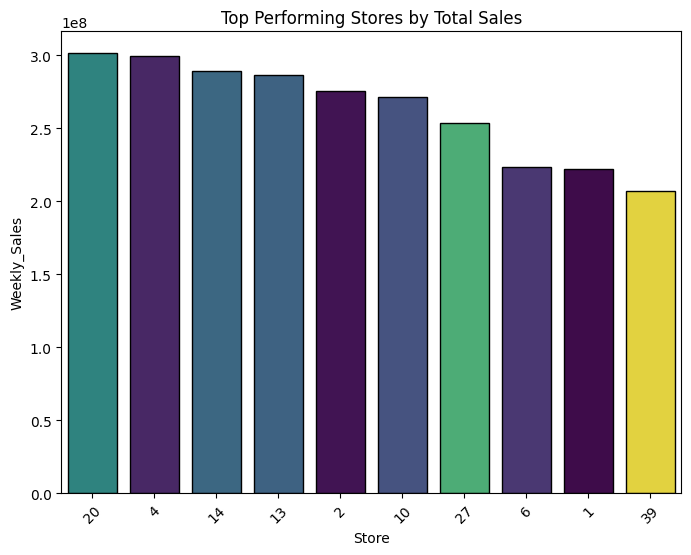

In [8]:
top_stores = df.groupby('Store')['Weekly_Sales'].sum().nlargest(10).reset_index() #Extracting the top 10 based on sales
plt.figure(figsize=(8,6))
sns.barplot(data=top_stores,x='Store',y='Weekly_Sales', hue='Store', palette='viridis', order=top_stores['Store'],legend=False,edgecolor='black')
plt.title('Top Performing Stores by Total Sales')
plt.xticks(rotation=45)
plt.show()

- Store Number  20, 4, 14, 13, 2, 10, 27, 6, 1, 39 are the top 10 stores based on total Sales

### <span style='color: GREEN;'>__*(f) Worst performing store*__</span>

In [9]:
best_worst = df.groupby('Store')['Weekly_Sales'].sum()
best = best_worst.idxmax() #returns the index of the maximum value
worst = best_worst.idxmin() #returns the index of the minimum value
best_worst = best_worst.loc[[best, worst]].reset_index()

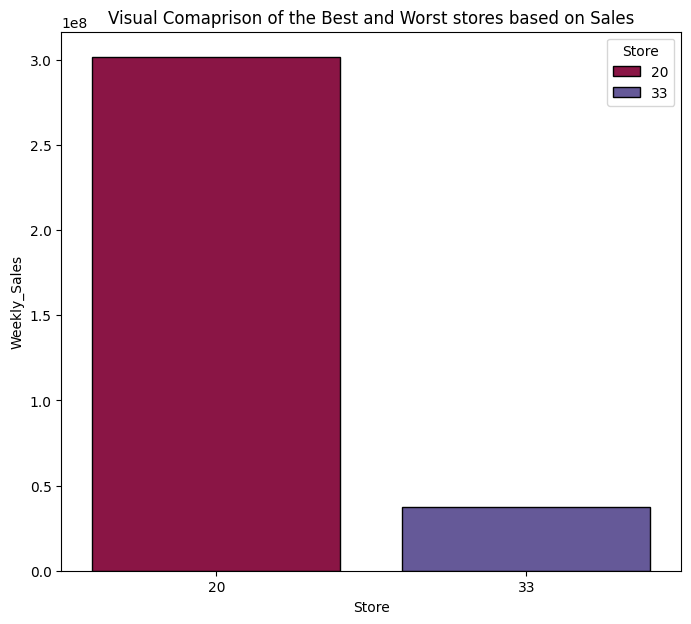

Difference between the Total Sales of THE BEST and THE WORST is:  264237570.49999997


In [10]:
plt.figure(figsize=(8,7))
sns.barplot(data=best_worst, x='Store', y='Weekly_Sales', hue='Store', palette='Spectral',edgecolor='black')
plt.title('Visual Comaprison of the Best and Worst stores based on Sales')
plt.show()
print('Difference between the Total Sales of THE BEST and THE WORST is: ',best_worst.iloc[0, 1] - best_worst.iloc[1,1] )

## <span style='color: GREEN;'>__*Model Building and Forecasting*__</span>

- Using store no-5 for Forecasting and Analysis

In [11]:
store_id = 5
store_data = (df[df['Store'] == store_id].set_index('Date').resample('W')['Weekly_Sales'].mean().fillna(method='ffill').to_frame())

/tmp/ipython-input-2597913565.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  store_data = (df[df['Store'] == store_id].set_index('Date').resample('W')['Weekly_Sales'].mean().fillna(method='ffill').to_frame())


In [12]:
store_data

,Weekly_Sales
Date,
2010-02-07,317173.10
2010-02-14,311825.70
2010-02-21,303447.57
2010-02-28,270281.63
2010-03-07,288855.71
...,...
2012-09-30,310141.68
2012-10-07,343048.29
2012-10-14,325345.41


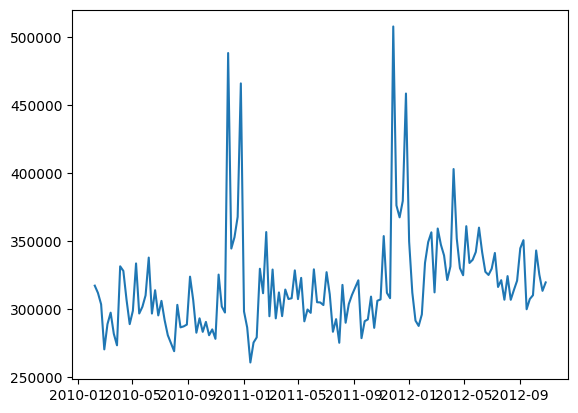

In [13]:
plt.plot(store_data)

Figure(640x480)


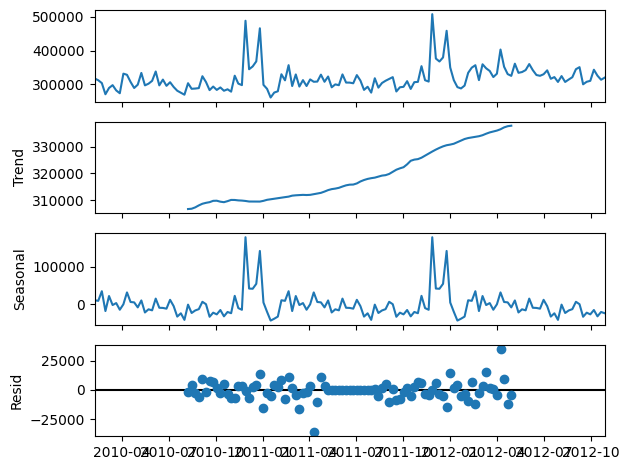

In [14]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposed=seasonal_decompose(store_data)
print(decomposed.plot())

In [15]:
from statsmodels.tsa.stattools import adfuller
test_result=adfuller(store_data)
test_result

(np.float64(-4.310974424060915),
 np.float64(0.00042517056141923293),
 4,
 138,
 {'1%': np.float64(-3.47864788917503),
  '5%': np.float64(-2.882721765644168),
  '10%': np.float64(-2.578065326612056)},
 np.float64(3038.49592982281))

In [16]:
pval=test_result[1]
pval

np.float64(0.00042517056141923293)

In [17]:
if pval<0.05:
    print('data is stationary')
else:
    print('data is not stationary')

data is stationary


In [18]:
store_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 143 entries, 2010-02-07 to 2012-10-28
Freq: W-SUN
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Weekly_Sales  143 non-null    float64
dtypes: float64(1)
memory usage: 2.2 KB


In [19]:
train=store_data.iloc[:130]['Weekly_Sales']
test=store_data.iloc[130:]['Weekly_Sales']

In [20]:
train

,Weekly_Sales
Date,
2010-02-07,317173.10
2010-02-14,311825.70
2010-02-21,303447.57
2010-02-28,270281.63
2010-03-07,288855.71
...,...
2012-07-01,329658.10
2012-07-08,341214.43
2012-07-15,316203.64


In [21]:
test

,Weekly_Sales
Date,
2012-08-05,324195.17
2012-08-12,306759.70
2012-08-19,314014.18
2012-08-26,320831.36
2012-09-02,344642.01
2012-09-09,350648.91
2012-09-16,299800.67
2012-09-23,307306.76
2012-09-30,310141.68


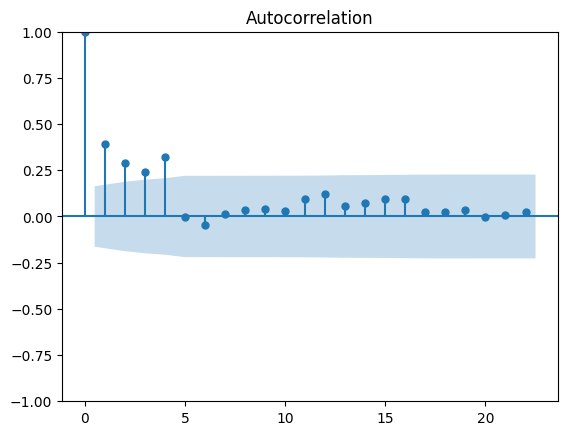

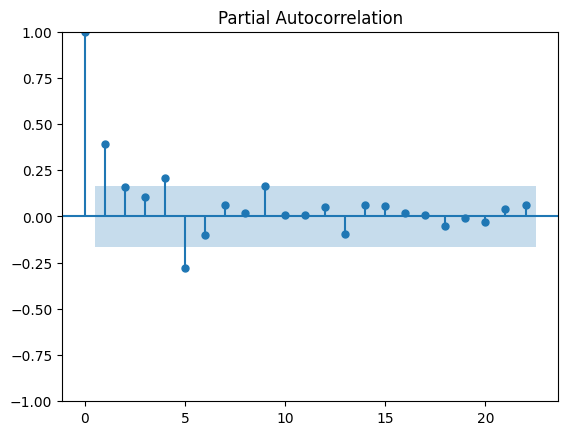

In [22]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(store_data['Weekly_Sales'])
plot_pacf(store_data['Weekly_Sales'])
plt.show()

### <span style='color: GREEN;'>__*ARMA Model*__</span>

In [23]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import *

In [24]:
import itertools
p=range(0,7)
d=range(0,1)
q=range(0,7)
pdq=list(itertools.product(p,d,q))
rmse=[]
order1=[]
for i in pdq:
    model=ARIMA(train,order=i)
    model_fit=model.fit()
    pred=model_fit.predict(start=len(train),end=len(train)+len(test)-1)
    error=np.sqrt(mean_squared_error(test,pred))
    order1.append(i)
    rmse.append(error)

results=pd.DataFrame(index=order1,data=rmse,columns=['RMSE'])

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:60

In [25]:
results.sort_values(by='RMSE',ascending=True)

,RMSE
"(5, 0, 6)",14886.077472
"(6, 0, 6)",14943.716718
"(5, 0, 5)",15048.853687
"(6, 0, 5)",15129.781279
"(6, 0, 4)",15633.252320
"(1, 0, 5)",15635.097687
"(0, 0, 6)",15641.560752
"(0, 0, 4)",15653.298570
"(2, 0, 4)",15656.819002
"(5, 0, 3)",15661.457062


In [26]:
A_model = ARIMA(train,order=(5,0,6))

In [27]:
A_model=A_model.fit()

In [43]:
store_data['ARIMA_Pridictions']=A_model.predict(start=len(train),end=len(train)+len(test)-1)
arima_pred=A_model.predict(start=len(train),end=len(train)+len(test)-1)

In [29]:
store_data

,Weekly_Sales,ARIMA_Pridictions
Date,,
2010-02-07,317173.10,NaN
2010-02-14,311825.70,NaN
2010-02-21,303447.57,NaN
2010-02-28,270281.63,NaN
2010-03-07,288855.71,NaN
...,...,...
2012-09-30,310141.68,319142.654482
2012-10-07,343048.29,319585.132802
2012-10-14,325345.41,319424.035368


<Axes: xlabel='Date'>

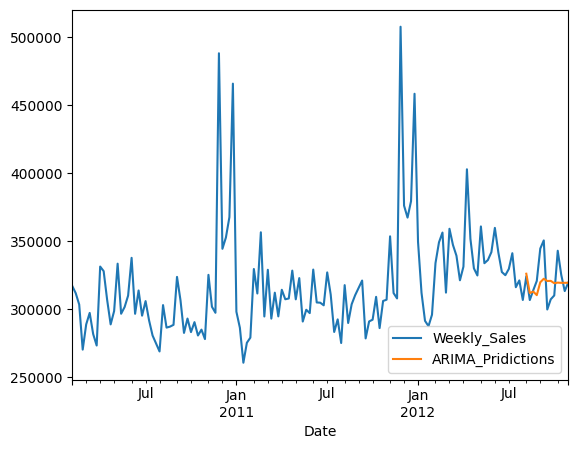

In [30]:
store_data[['Weekly_Sales','ARIMA_Pridictions']].plot()

- above graph shows that ARMA Model is not suitable for forcasting so going for SARIMA Model.

### <span style='color: GREEN;'>__*SARIMA Model*__</span>

In [31]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [32]:
model=SARIMAX(train,order=(1,0,1),seasonal_order=(1,0,1,52))
model=model.fit()

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


In [33]:
store_data['SARIMA_Pridictions']=model.predict(start=len(train),end=len(train)+len(test)-1)
sarima_pred=model.predict(start=len(train),end=len(train)+len(test)-1)

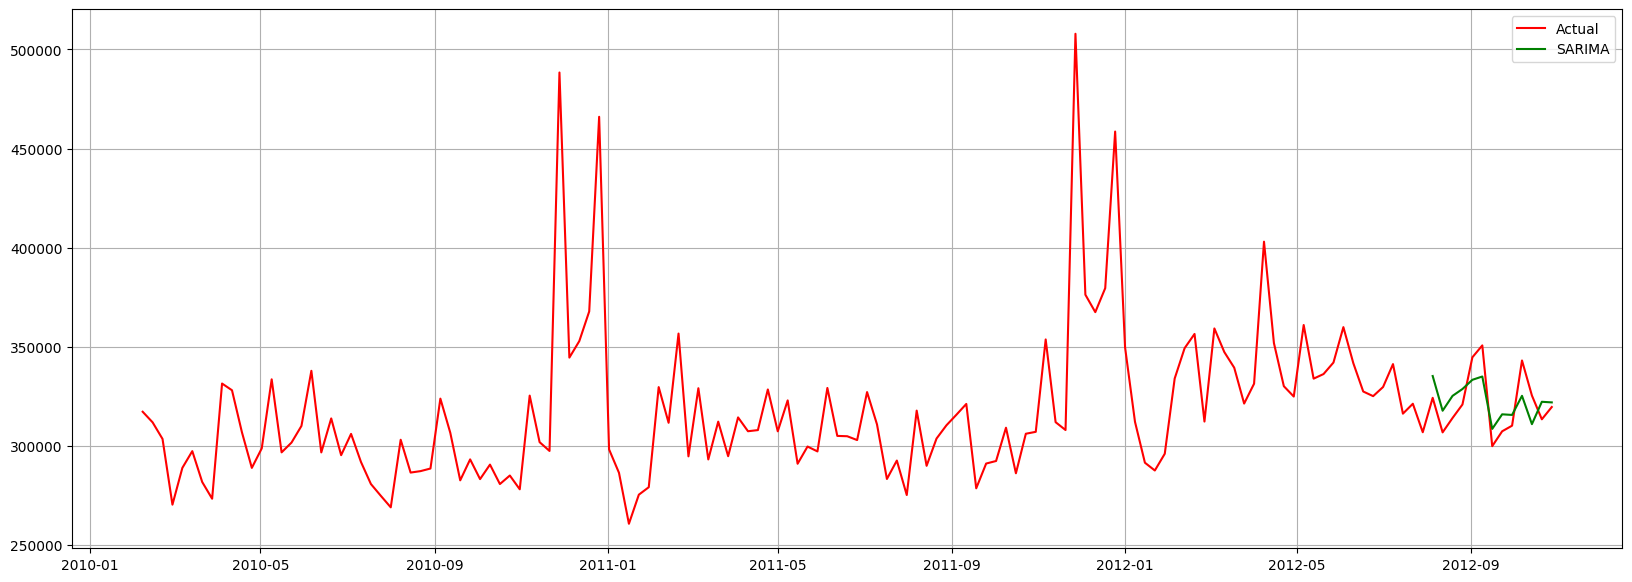

In [34]:
plt.figure(figsize=(20,7))
plt.plot(store_data.index, store_data['Weekly_Sales'], label='Actual', color='red')
plt.plot(test.index, store_data.loc[test.index, 'SARIMA_Pridictions'], label='SARIMA', color='green')
plt.grid()
plt.legend()
plt.show()

- the above graph shows Sarima model is predicting good compared to ARMA model.

## <span style='color: GREEN;'>__*PROPHET Model*__</span>

In [35]:
%pip install prophet

In [36]:

%pip install cmdstanpy

In [37]:
df31 = df.loc[df['Store'] == 5] #slicing to get only data of Store Number 5
df31

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Month
572,5,2010-02-05,317173.10,0,39.70,2.572,211.653972,6.566,2
573,5,2010-02-12,311825.70,1,39.81,2.548,211.800470,6.566,2
574,5,2010-02-19,303447.57,0,41.14,2.514,211.847128,6.566,2
575,5,2010-02-26,270281.63,0,46.70,2.561,211.877147,6.566,2
576,5,2010-03-05,288855.71,0,48.89,2.625,211.907165,6.566,3
...,...,...,...,...,...,...,...,...,...
710,5,2012-09-28,310141.68,0,78.33,3.666,223.574102,5.603,9
711,5,2012-10-05,343048.29,0,71.17,3.617,223.774444,5.422,10
712,5,2012-10-12,325345.41,0,66.24,3.601,223.974787,5.422,10
713,5,2012-10-19,313358.15,0,69.17,3.594,224.019287,5.422,10


In [38]:
df31.rename(columns={'Date':'ds', 'Weekly_Sales':'y'}, inplace=True)
df31= df31[['ds', 'y']]

/tmp/ipython-input-3558126007.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df31.rename(columns={'Date':'ds', 'Weekly_Sales':'y'}, inplace=True)


In [39]:
from prophet import Prophet
model = Prophet()
model = model.fit(df31)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp33zgahsw/pc4itoeu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp33zgahsw/t9csmc3m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81690', 'data', 'file=/tmp/tmp33zgahsw/pc4itoeu.json', 'init=/tmp/tmp33zgahsw/t9csmc3m.json', 'output', 'file=/tmp/tmp33zgahsw/prophet_modelfy9ufc91/prophet_model-20251025131624.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:16:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:16:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [40]:
future =  model.make_future_dataframe(periods=12, freq='W') #12 weeks
forecast = model.predict(future)

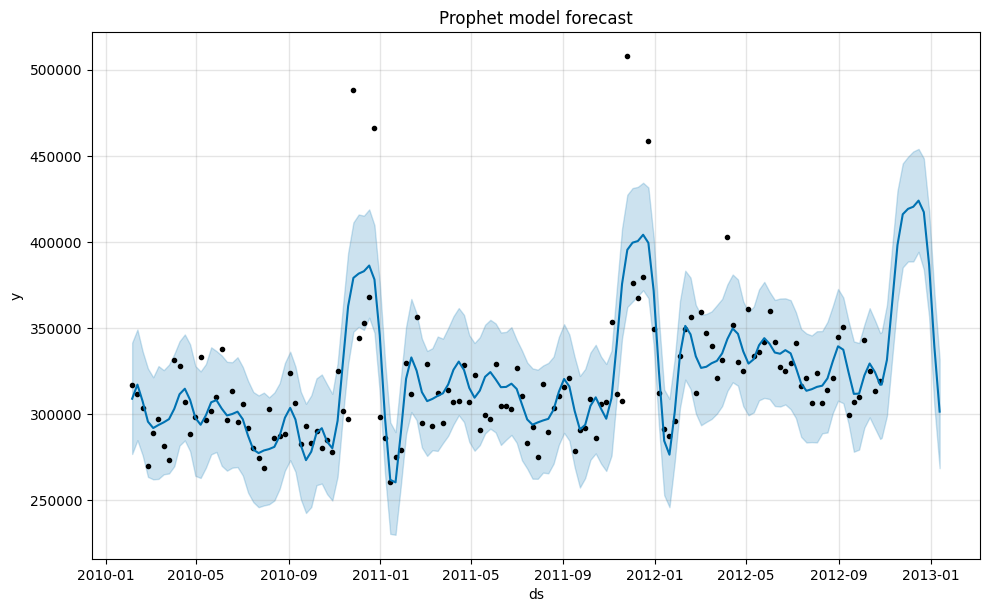

In [41]:
model.plot(forecast)
plt.title("Prophet model forecast")
plt.show()

In [52]:
# If 'test' is a Series, convert to DataFrame:
test_df = test.to_frame()

# Now you can inspect columns:
print(test_df.columns)
print(test_df.head())


Index(['Weekly_Sales'], dtype='object')
            Weekly_Sales
Date                    
2012-08-05     324195.17
2012-08-12     306759.70
2012-08-19     314014.18
2012-08-26     320831.36
2012-09-02     344642.01


In [59]:
from sklearn.metrics import root_mean_squared_error

# Make sure indices are DatetimeIndex
forecast['ds'] = pd.to_datetime(forecast['ds'])
test_df.index = pd.to_datetime(test_df.index)

# Reindex Prophet forecast to test index (will insert NaN for missing dates)
forecasted = forecast.set_index('ds').reindex(test_df.index)['yhat']

# Report if any missing predictions
missing_dates = forecasted[forecasted.isna()].index
if len(missing_dates) > 0:
    print("Missing dates in Prophet forecast:", missing_dates)

# Remove missing dates from both forecast and actuals before computing RMSE
valid_idx = ~forecasted.isna() & ~test_df['Weekly_Sales'].isna()
rmse = root_mean_squared_error(test_df['Weekly_Sales'][valid_idx], forecasted[valid_idx])
rmse_arma = root_mean_squared_error(test_df['Weekly_Sales'], arima_pred)
rmse_sarima = root_mean_squared_error(test_df['Weekly_Sales'],sarima_pred)


Missing dates in Prophet forecast: DatetimeIndex(['2012-08-05', '2012-08-12', '2012-08-19', '2012-08-26',
               '2012-09-02', '2012-09-09', '2012-09-16', '2012-09-23',
               '2012-09-30', '2012-10-07', '2012-10-14', '2012-10-21'],
              dtype='datetime64[ns]', name='Date', freq='W-SUN')


In [60]:
print("Prophet RMSE: ", rmse)
print("ARMA RMSE: ",rmse_arma)
print("SARIMA RMSE: ",rmse_sarima)

Prophet RMSE:  2328.817867970618
ARMA RMSE:  14886.077472173589
SARIMA RMSE:  11061.553242066335


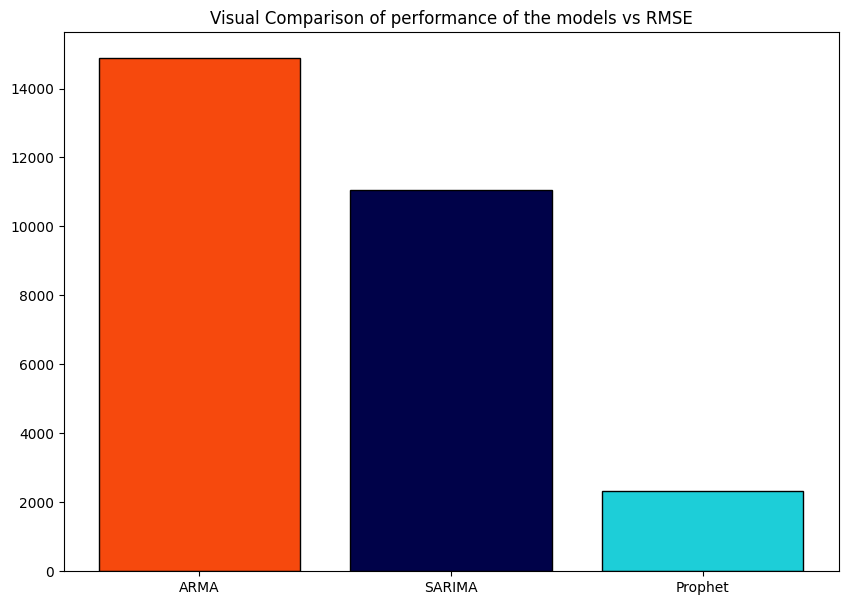

In [67]:
plt.figure(figsize=(10,7))
plt.bar(['ARMA', 'SARIMA', 'Prophet'], [rmse_arma, rmse_sarima, rmse], color=['#F6490D', '#000249', '#1DCED8'], edgecolor='black')
plt.title("Visual Comparison of performance of the models vs RMSE")
plt.show()

email-->akashbhavanisankar@gmail.com